In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import glob
import functools
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import quantities as pq

import epych
from epych.statistics import alignment

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
NWB_SUBJECTS = glob.glob('/mnt/data/DRAFT/000253/sub-*/')

In [7]:
for s, subject_dir in enumerate(sorted(NWB_SUBJECTS)):
    if os.path.exists(subject_dir + '/gonaive'):
        logging.info('Pulled out gonaive LFPs for %s' % subject_dir)
        continue
    if not os.path.exists(subject_dir + '/go_gloexp'):
        continue
    go_gloexp = epych.recording.Sampling.unpickle(subject_dir + '/go_gloexp')
    go_naive = go_gloexp.select_trials(go_gloexp.trials.index < 10)
    go_naive.pickle(subject_dir + '/gonaive')
    logging.info('Pulled out gonaive LFPs for %s' % subject_dir)
    del go_gloexp
    del go_naive

INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-621890/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-632485/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-632487/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-637542/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-637908/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-637909/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-640507/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-642507/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-645322/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-645324/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-645495/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-647836/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRAFT/000253/sub-649323/
INFO:root:Pulled out gonaive LFPs for /mnt/data/DRA

In [8]:
def visual_align(signal):
    return signal.select_channels(["VIS" in loc for loc in signal.channels.location]).median_filter()

In [9]:
NUM_TRIALS = 0
ODDBALL_ONSET = 0.
ODDBALL_OFFSET = 0.

In [10]:
aligner = epych.statistics.alignment.AlignmentSummary.unpickle("/mnt/data/DRAFT/000253/visual_alignment")

In [11]:
def samplings(cond):
    for s, subject_dir in enumerate(sorted(NWB_SUBJECTS)):
        subject = subject_dir.split('/')[-2]
        if not os.path.exists(subject_dir + "/" + cond):
            continue
        sampling = epych.recording.Sampling.unpickle(subject_dir + "/" + cond).smap(visual_align)
        global ODDBALL_ONSET
        global ODDBALL_OFFSET
        global NUM_TRIALS
        ODDBALL_ONSET += sampling.trials['stim3_start'].sum()
        ODDBALL_OFFSET += sampling.trials['stim3_end'].sum()
        NUM_TRIALS += len(sampling.trials)
        yield sampling
        del sampling
        logging.info("Loaded LFPs for %s in subject %s" % (cond, subject))

In [12]:
def initialize_grandcat(key, signal):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.grand.GrandConcatenation(aligner.stats[area])

In [13]:
erps = {}

In [14]:
summary = epych.statistic.Summary(alignment.location_prefix, initialize_grandcat)
summary.calculate(samplings("gonaive"))
cat = summary.results()
cat.pickle("/mnt/data/DRAFT/000253/grandcat_gonaive")
erps["gonaive"] = cat.erp()
logging.info("Grand-concatenated LFPs for condition gonaive")
del summary
del cat

INFO:root:Loaded LFPs for gonaive in subject sub-621890
INFO:root:Loaded LFPs for gonaive in subject sub-632485
INFO:root:Loaded LFPs for gonaive in subject sub-632487
INFO:root:Loaded LFPs for gonaive in subject sub-637542
INFO:root:Loaded LFPs for gonaive in subject sub-637908
INFO:root:Loaded LFPs for gonaive in subject sub-637909
INFO:root:Loaded LFPs for gonaive in subject sub-640507
INFO:root:Loaded LFPs for gonaive in subject sub-642507
INFO:root:Loaded LFPs for gonaive in subject sub-645322
INFO:root:Loaded LFPs for gonaive in subject sub-645324
INFO:root:Loaded LFPs for gonaive in subject sub-645495
INFO:root:Loaded LFPs for gonaive in subject sub-647836
INFO:root:Loaded LFPs for gonaive in subject sub-649323
INFO:root:Loaded LFPs for gonaive in subject sub-649324
INFO:root:Grand-concatenated LFPs for condition gonaive


In [15]:
ODDBALL_ONSET /= NUM_TRIALS
ODDBALL_OFFSET /= NUM_TRIALS
events = {
    "Oddball Onset": (ODDBALL_ONSET, 'lightgreen'),
    "Oddball Offset": (ODDBALL_OFFSET, 'red'),
}

In [16]:
PRETRIAL_SECONDS = 0.5

In [17]:
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

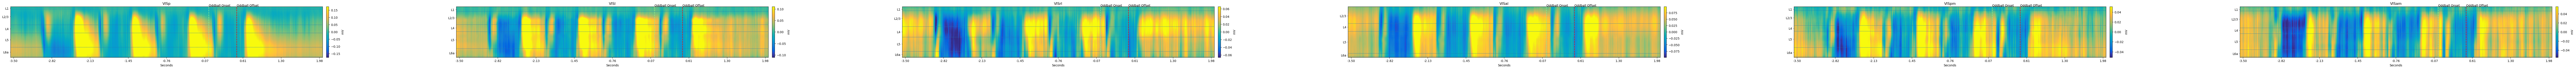

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


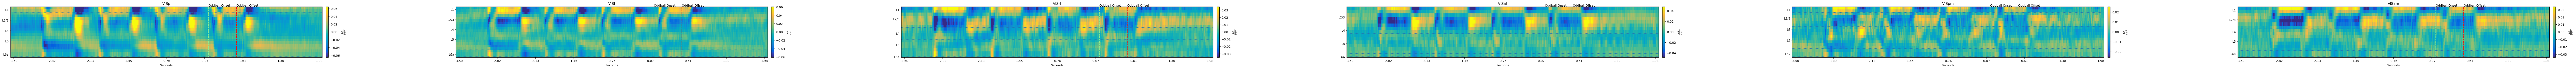

INFO:root:Plotted grand-averaged LFPs, CSDs for condition gonaive


In [18]:
lfp_erp = erps["gonaive"].baseline_correct(0, PRETRIAL_SECONDS)
for sig in lfp_erp.signals.values():
    sig._data = sig.data.rescale('mV')
lfp_erp.plot(signals=anatomical_areas, **events)

csd = erps["gonaive"].smap(lambda sig: sig.downsample(4).current_source_density(depth_column="vertical"))
for sig in csd.signals.values():
    sig._data = sig.data.rescale('nA / mm**2')
csd.plot(signals=anatomical_areas, **events)
logging.info("Plotted grand-averaged LFPs, CSDs for condition gonaive")